辨識名畫的作家 使用 CNN 模型學習辨識

In [ ]:
import random
import os 
# 資料來源

if(os.path.isfile("./train.zip") == False):
  rand = random.randint(0,9)
  if (rand < 5):
    !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
    !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
    !echo "分流1"
  else:
    !wget -O train.zip "http://140.115.82.54/NN/ART/train.zip"
    !wget -O test.zip "http://140.115.82.54/NN/ART/test.zip"
    !echo "分流2"
  !unzip train.zip
  !unzip test.zip 
else:
  !echo "檔案已存在"

串流輸出內容已截斷至最後 5000 行。
  inflating: train_resized/Joan_Miro_27.jpg  
  inflating: train_resized/Joan_Miro_28.jpg  
  inflating: train_resized/Joan_Miro_29.jpg  
  inflating: train_resized/Joan_Miro_3.jpg  
  inflating: train_resized/Joan_Miro_30.jpg  
  inflating: train_resized/Joan_Miro_31.jpg  
  inflating: train_resized/Joan_Miro_32.jpg  
  inflating: train_resized/Joan_Miro_33.jpg  
  inflating: train_resized/Joan_Miro_34.jpg  
  inflating: train_resized/Joan_Miro_35.jpg  
  inflating: train_resized/Joan_Miro_36.jpg  
  inflating: train_resized/Joan_Miro_37.jpg  
  inflating: train_resized/Joan_Miro_39.jpg  
  inflating: train_resized/Joan_Miro_4.jpg  
  inflating: train_resized/Joan_Miro_40.jpg  
  inflating: train_resized/Joan_Miro_42.jpg  
  inflating: train_resized/Joan_Miro_43.jpg  
  inflating: train_resized/Joan_Miro_44.jpg  
  inflating: train_resized/Joan_Miro_45.jpg  
  inflating: train_resized/Joan_Miro_46.jpg  
  inflating: train_resized/Joan_Miro_47.jpg  
  inflating: tr

## 1. 讀入封包

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from collections import Counter

## 2. 取得資料集

  - 畫家名稱(name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有50位畫家

In [ ]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ",num_classes)
artists.head()

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [ ]:
artists = artists.loc[:,["name","paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

,name,paintings
0,Amedeo_Modigliani,193
1,Vasiliy_Kandinskiy,88
2,Diego_Rivera,70
3,Claude_Monet,73
4,Rene_Magritte,194


可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


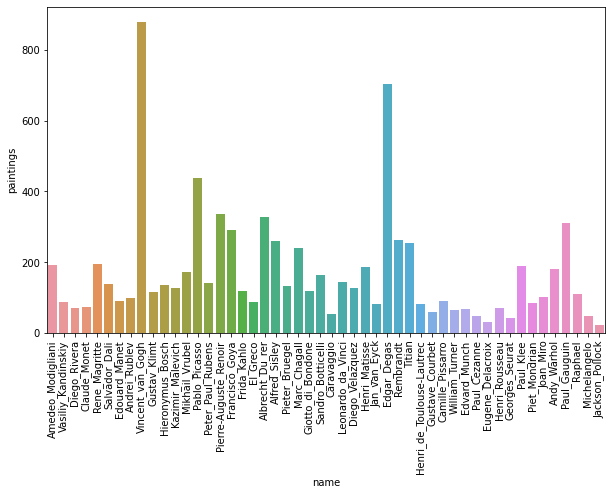

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(artists.name,artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)
    
print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ",artists.paintings.max()," 最少畫作為 : ",artists.paintings.min())

training 畫作總共畫作有 :  7520


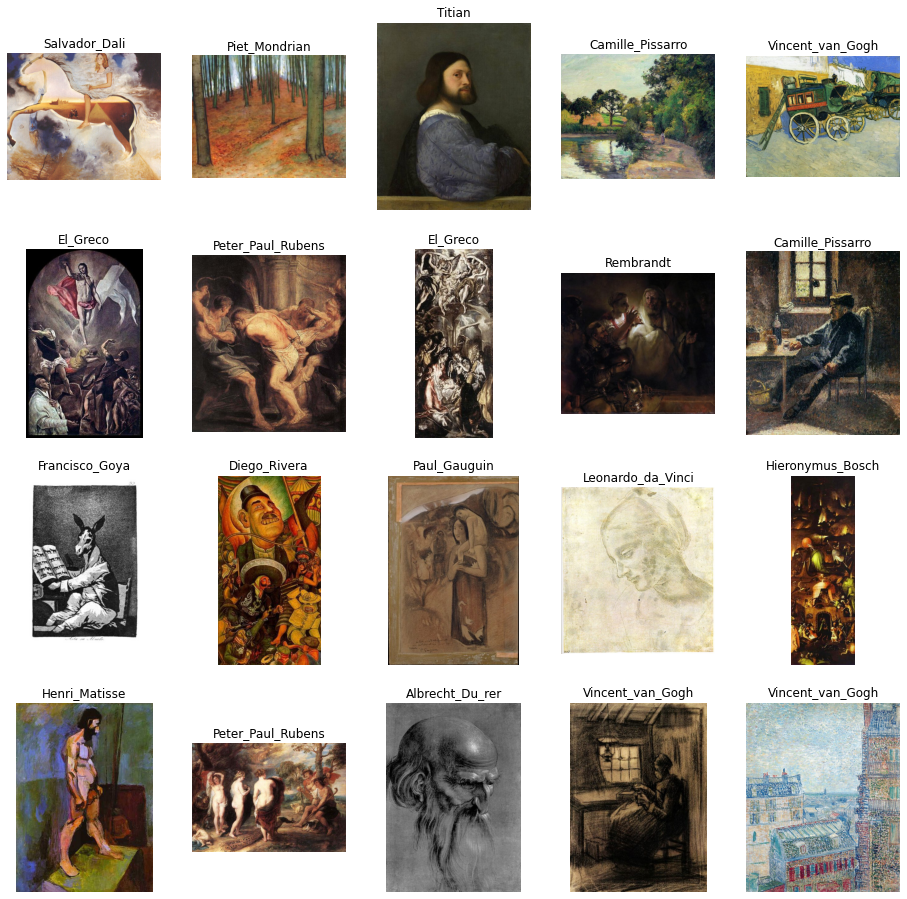

In [ ]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
randomlist = random.sample(range(0,total_len), 20)
print("training 畫作總共畫作有 : ",total_len)

show_imgs = [img_list[rand] for rand in randomlist]

plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1])) #去掉最後的 jpg 部分

## 3. 資料前處理





In [ ]:

img_list = os.listdir(train_dir)

def make_Authordict():
 
  # 數字映射成英文
  arrimg = []
  dictindex = 0
  dictimg = {}
  for name in img_list : 
    artistName = "_".join(name.split("_")[:-1])
    if(artistName not in arrimg):
      arrimg.append(artistName)
      dictimg[dictindex] = artistName
      dictindex +=1;
      
  return dictimg

class_name = make_Authordict()
rev_class_name = dict(zip(class_name.values(), class_name.keys())) # 英文映射成數字
print(class_name)
print(rev_class_name) 
# 請建立將數字映射成英文的dict。 EX: 0 --> Van_Gogh


{0: 'Marc_Chagall', 1: 'Frida_Kahlo', 2: 'Titian', 3: 'Edgar_Degas', 4: 'Rembrandt', 5: 'Pieter_Bruegel', 6: 'Francisco_Goya', 7: 'El_Greco', 8: 'Vincent_van_Gogh', 9: 'Mikhail_Vrubel', 10: 'Alfred_Sisley', 11: 'Giotto_di_Bondone', 12: 'Andy_Warhol', 13: 'Henri_Matisse', 14: 'Edvard_Munch', 15: 'Albrecht_Du_rer', 16: 'Peter_Paul_Rubens', 17: 'Edouard_Manet', 18: 'Michelangelo', 19: 'Paul_Klee', 20: 'Pierre-Auguste_Renoir', 21: 'Salvador_Dali', 22: 'Caravaggio', 23: 'Joan_Miro', 24: 'Henri_de_Toulouse-Lautrec', 25: 'Vasiliy_Kandinskiy', 26: 'Pablo_Picasso', 27: 'Amedeo_Modigliani', 28: 'Gustav_Klimt', 29: 'Paul_Gauguin', 30: 'Rene_Magritte', 31: 'Paul_Cezanne', 32: 'Hieronymus_Bosch', 33: 'Andrei_Rublev', 34: 'Leonardo_da_Vinci', 35: 'Raphael', 36: 'Diego_Rivera', 37: 'Georges_Seurat', 38: 'Kazimir_Malevich', 39: 'Camille_Pissarro', 40: 'Diego_Velazquez', 41: 'Henri_Rousseau', 42: 'Sandro_Botticelli', 43: 'William_Turner', 44: 'Claude_Monet', 45: 'Jan_van_Eyck', 46: 'Piet_Mondrian', 47:

In [ ]:
def get_label(picName):
  # 請取出label並轉成數字
  
  class_name = make_Authordict()
  picName = "_".join(picName.split('_')[:-1])
  for key in class_name:
    if(class_name[key] == picName):
      return key

  
def get_path(dir,picName):

  path = dir + picName
  return path

def make_paths_label(dir):
  img_list = os.listdir(dir) # ./train_resized/
  paths = []
  labels = []
  for index,img in enumerate(img_list):
    paths.append(get_path(dir,img))
    labels.append(get_label(img))

  # 將preprocess完成的path、label用for迴圈放入paths和labels
  # 將labels轉成onehot

  onehot_labels = tf.one_hot(labels,50)
  return paths,onehot_labels
  

In [ ]:

paths,onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
  print(p)
print("-"*20)
print("labels : ")
for label in onehot_labels[:5]:
  print(label)

paths : 
./train_resized/Marc_Chagall_115.jpg
./train_resized/Frida_Kahlo_117.jpg
./train_resized/Titian_171.jpg
./train_resized/Edgar_Degas_668.jpg
./train_resized/Rembrandt_246.jpg
--------------------
labels : 
tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)
tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)
tf.Tensor(
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)
tf.Tensor(
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)
tf.Tensor(

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [ ]:

paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
  print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Marc_Chagall_115.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Frida_Kahlo_117.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Titian_171.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Edgar_Degas_668.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Rembrandt_246.jpg', shape=(), dtype=string)


In [ ]:

#圖片長寬
# shuffle buffle size
IMG_WIDTH = 224
IMG_HEIGHT = 256

shuffle_buffer = 1000 

def get_image(path):
  # read image from path
  file = tf.io.read_file(path)
  img = tf.io.decode_jpeg(file,channels=3)
  img = tf.cast(img,tf.float32)
  
  img = tf.image.resize(img,size=(IMG_WIDTH,IMG_HEIGHT))  

  img = img/255.0;
 
  print(img)
 
  return img

def make_dataset(dir):
  paths,onehot_labels = make_paths_label(dir)
  paths_ds = tf.data.Dataset.from_tensor_slices(paths)
  train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)


  train_image = paths_ds.map(get_image)
  # 合併圖片與label資料集
  full_ds = tf.data.Dataset.zip((train_image,train_label))
  # 打散
  full_ds = full_ds.shuffle(shuffle_buffer,reshuffle_each_iteration=False)
  return full_ds

full_ds = make_dataset(train_dir)

Tensor("truediv:0", shape=(224, 256, 3), dtype=float32)


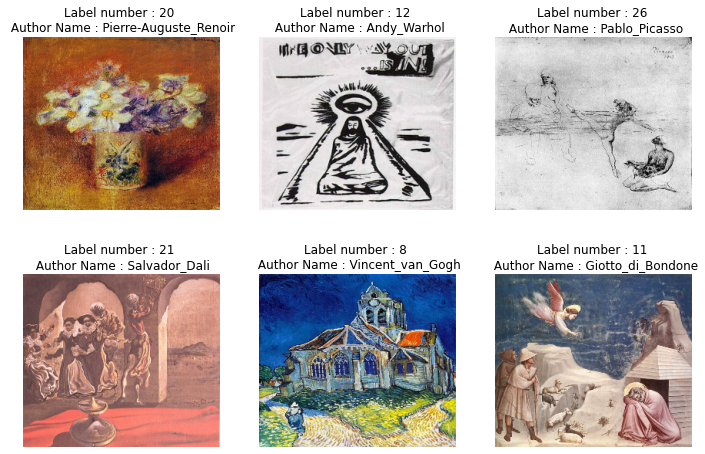

In [ ]:
# 取出Tensor圖片來看看
plt.figure(figsize=(12, 8))
for index,(img,label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(
        l,
        class_name[l])) # class_name 的 item 是畫家名字
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [ ]:
# 切割成training data與validation data
train_len = int(0.8*total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ",train_len," val size : ",val_len)

# 添加batch
# todo
batch_size = 128

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train size :  6016  val size :  1504


In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (128, 224, 256, 3)
training label batch shape :  (128, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做fine-tuning，**請自己手動建**。

In [ ]:
input_shape = (224,256,3)

model = keras.Sequential(
    [
      keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu",padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu",padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu",padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu",padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)



model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 256, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 32, 64)       

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [ ]:


epochs = 40

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/40
47/47 [==============================] - 72s 1s/step - loss: 3.6394 - accuracy: 0.1047 - val_loss: 3.4315 - val_accuracy: 0.1483
Epoch 2/40
47/47 [==============================] - 69s 1s/step - loss: 3.2725 - accuracy: 0.1791 - val_loss: 2.9950 - val_accuracy: 0.2334
Epoch 3/40
47/47 [==============================] - 69s 1s/step - loss: 2.9648 - accuracy: 0.2410 - val_loss: 2.7610 - val_accuracy: 0.2899
Epoch 4/40
47/47 [==============================] - 69s 1s/step - loss: 2.7058 - accuracy: 0.2900 - val_loss: 2.5463 - val_accuracy: 0.3338
Epoch 5/40
47/47 [==============================] - 69s 1s/step - loss: 2.4953 - accuracy: 0.3377 - val_loss: 2.5479 - val_accuracy: 0.3378
Epoch 6/40
47/47 [==============================] - 70s 1s/step - loss: 2.2807 - accuracy: 0.3896 - val_loss: 2.3597 - val_accuracy: 0.3690
Epoch 7/40
47/47 [==============================] - 69s 1s/step - loss: 2.0358 - accuracy: 0.4465 - val_loss: 2.4208 - val_accuracy: 0.3491
Epoch 8/40
47/47 [==

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


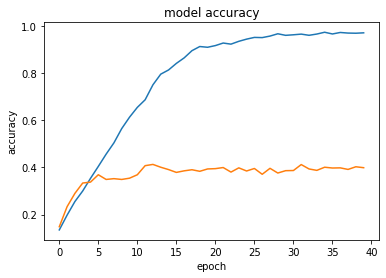

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

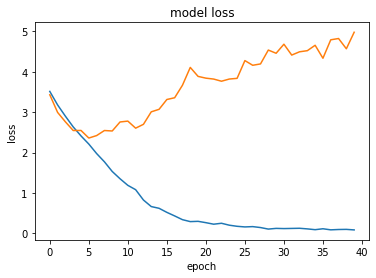

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Tensor("truediv:0", shape=(224, 256, 3), dtype=float32)
7/7 [==============================] - 5s 190ms/step - loss: 5.0337 - accuracy: 0.4120
Test loss: 5.033665180206299
Test accuracy: 0.41197603940963745


## 7. 做預測


In [ ]:
def preditAuthor(img):

  authorName = ""
 
  img = img.reshape(1,IMG_HEIGHT,IMG_WIDTH,3)

  index = np.argmax(model.predict(img)[0])
  authorName = class_name[index]
  return authorName

'Edgar_Degas'

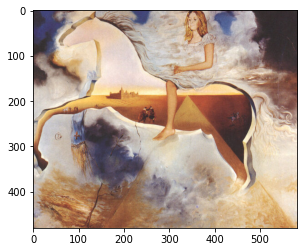

In [ ]:
# 測試
imgpath = train_dir+show_imgs[0]
img = cv.imread(imgpath)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)
img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
img = img / 255.0
preditAuthor(img)


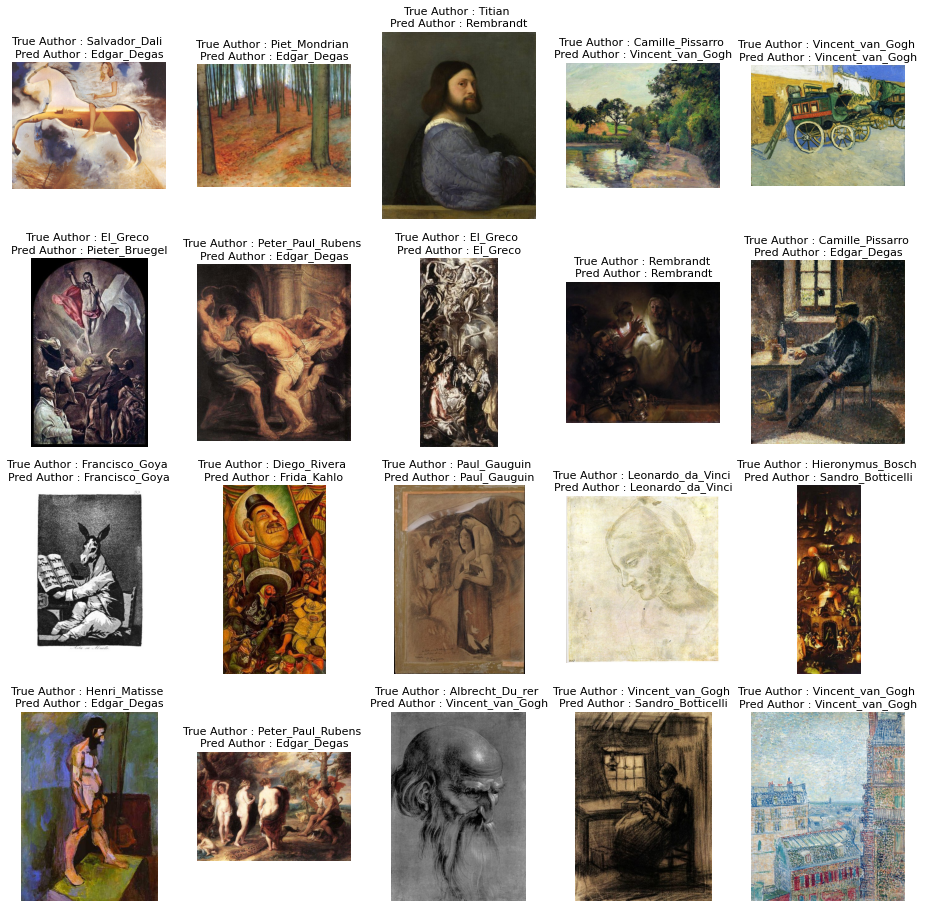

In [ ]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
  imgpath = train_dir+imgName
  img = cv.imread(imgpath)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.subplot(4,5,index+1)
  plt.axis("off")
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img / 255.0
  plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]),preditAuthor(img)),size=11)

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)